#Multilayer Perceptron (MLP)

이 튜토리얼에서는 신경망의 기본 모델인 MLP에 대해 알아볼 것입니다.<br>
본 튜토리얼에서는 비선형 나선 데이터에 선형 모델(로지스틱 회귀)을 맞추려고(fit) 시도하여 비선형 활성화 함수에 대한 필요성을 강조할 것 입니다.<br>

# Overview

머신 러닝의 목표는 모델에게 𝑋가 주어졌을때 𝑦를 내보내는 모델 𝑦̂를 학습하는 것입니다.

신경망은 _일반화 된 선형 기법의 확장_ 일 뿐이고 데이터가 매우 <font color=red>비선형</font>이기 때문에 __비선형 활성화 함수를 사용__ 합니다.


<div align="left">
<img src="https://raw.githubusercontent.com/LEE-SEON-WOO/DL-Tutorials-Py_or_Tf/master/notebooks/09_Multilayer_Perceptrons/mlp.png" width="550">
</div>

$z_1 = XW_1$

$a_1 = f(z_1)$

$z_2 = a_1W_2$

$\hat{y} = softmax(z_2)$ # 분류

* $X$ = 입력 | $\in \mathbb{R}^{NXD}$ ($D$ = 특성의 수)
* $W_1$ = 첫번째 레이어의 가중치 | $\in \mathbb{R}^{DXH}$ ($H$는 레이어의 히든 유닛 수)
* $z_1$ = 첫 레이어로부터의 출력  $\in \mathbb{R}^{NXH}$
* $f$ = 비선형 활성 함수
* $a_1$ = 활성 함수가 적용된 첫 번째 레이어의 출력 | $\in \mathbb{R}^{NXH}$
* $W_2$ = 두 번째 레이어의 가중치 | $\in \mathbb{R}^{HXC}$ ($C$ = 클래스의 수)
* $z_2$ = 두 번째 레이어의 출력  $\in \mathbb{R}^{NXH}$
* $\hat{y}$ = 예측 | $\in \mathbb{R}^{NXC}$ ($N$ = 샘플의 수)

## MLP
* **목표:** $X$가 주어졌을때 $y$ 클래스의 확률을 예측. (비 선형성은 복잡하고 비 선형적인 데이터를 모델링하기위해 도입됨.)
* **장점:**
  * 비 선형적 패턴을 잘 모델링 가능
* **단점:**
  * 쉽게 과적화됨
  * 네트워크 사이즈가 커질수록  계산 집약적임
  * 쉽게 해석되지 않음
* **기타:** 최근 신경망 구조에서는 MLP를 feed forward 연산을 위한 모듈식 유닛(XW + 활성 함수)으로 사용하게 됩니다.

**Note**: 본 튜토리얼에서는 역전파 계산이 덜 복잡하도록 하기 위해 편향 항은 생략 할 것입니다.

# Data

## 데이터 불러오기

먼저 분류를 위한 비선형 데이터를 다운로드 합니다.

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [162]:
SEED = 1234
DATA_FILE = "spiral.csv"

In [163]:
# Set seed for reproducibility
np.random.seed(SEED)

In [164]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/LEE-SEON-WOO/DL-Tutorials-Py_or_Tf/master/data/spiral.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [165]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[['X1', 'X2']].values
y = df['color'].values
df.head(5)

,X1,X2,color
0,0.000000,0.000000,c1
1,-0.000457,0.001951,c1
2,0.001194,0.003826,c1
3,-0.000231,0.006008,c1
4,-0.000896,0.007966,c1


In [166]:
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


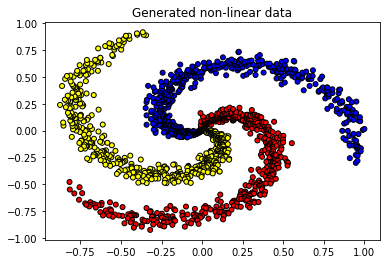

In [167]:
# Visualize data
plt.title("Generated non-linear data")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

## 데이터 분리

In [168]:
import collections
from sklearn.model_selection import train_test_split

In [169]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [170]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [171]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (1083, 2), y_train: (1083,)
X_val: (192, 2), y_val: (192,)
X_test: (225, 2), y_test: (225,)
Sample point: [ 0.23623443 -0.59618506] → c1
Classes: {'c1': 500, 'c3': 500, 'c2': 500}


## 레이블 인코더

In [172]:
from sklearn.preprocessing import LabelEncoder

In [173]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [174]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [175]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [176]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({0: 361, 2: 361, 1: 361}),
class weights: {0: 0.002770083102493075, 2: 0.002770083102493075, 1: 0.002770083102493075}


## 데이터 표준화

최적화를 빠르게하기 위해 데이터를 표준화할 필요가 있습니다.<br>
출력 y는 클래스 값이기 때문에 입력 X만 표준화 합니다.

In [177]:
from sklearn.preprocessing import StandardScaler

In [178]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [179]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [180]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: 0.0, std: 1.0
X_val[0]: mean: 0.1, std: 1.0
X_val[1]: mean: 0.0, std: 1.0
X_test[0]: mean: 0.1, std: 1.0
X_test[1]: mean: -0.1, std: 0.9


# 선형 모델

신경망을 사용하기 전, 우리는 선형 모델(로지스틱 회귀)을 구현하고 비선형 활성화 함수의 중요성을 확인해 볼 것입니다.<br>
먼저 선형 모델(선형 활성화 포함)이 데이터 세트에 충분하지 않은 이유를 알아보겠습니다.

In [181]:
import torch

In [182]:
# Set seed for reproducibility
torch.manual_seed(SEED)

## Model

In [183]:
from torch import nn
import torch.nn.functional as F

In [184]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes

In [185]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = self.fc1(x_in) # linear activation
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [186]:
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


## Training

In [187]:
from torch.optim import Adam

In [188]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [189]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [190]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [191]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [192]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [193]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.13, accuracy: 50.0
Epoch: 1 | loss: 0.91, accuracy: 51.0
Epoch: 2 | loss: 0.79, accuracy: 55.2
Epoch: 3 | loss: 0.74, accuracy: 54.8
Epoch: 4 | loss: 0.74, accuracy: 53.4
Epoch: 5 | loss: 0.75, accuracy: 53.6
Epoch: 6 | loss: 0.76, accuracy: 53.6
Epoch: 7 | loss: 0.77, accuracy: 53.6
Epoch: 8 | loss: 0.78, accuracy: 53.6
Epoch: 9 | loss: 0.78, accuracy: 53.5


## Evaluation

In [194]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [195]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [196]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [197]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0027, 0.0409, 0.9564], grad_fn=<SelectBackward>)
sample class: 2


In [198]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.54, test acc: 0.54


<ipython-input-195-c4b3e1cd4909>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-195-c4b3e1cd4909>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


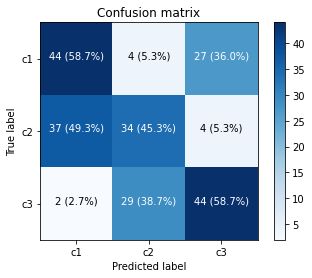

              precision    recall  f1-score   support

           0       0.53      0.59      0.56        75
           1       0.51      0.45      0.48        75
           2       0.59      0.59      0.59        75

    accuracy                           0.54       225
   macro avg       0.54      0.54      0.54       225
weighted avg       0.54      0.54      0.54       225



In [199]:
# Metrics
plot_confusion_matrix(y_test, pred_test, classes=classes)
print (classification_report(y_test, pred_test))

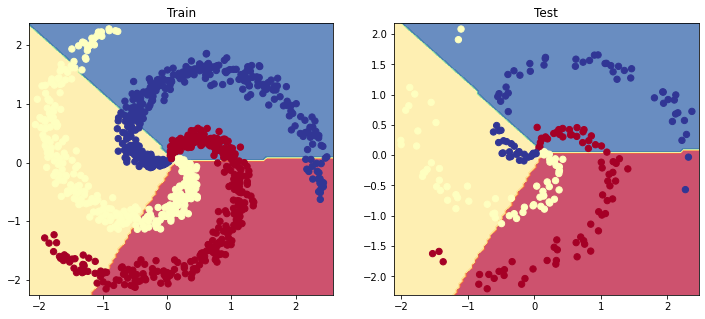

In [200]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# 활성화 함수

선형 기법을 사용했지만 데이터에 존재하는 <font color=red>비선형성</font> 때문에 좋지 않은 결과를 얻었었고, 이때의 활성화 함수는 __선형__ 이었습니다.<br>
모델이 데이터의 비선형성을 학습하기 위해서는 <font color=blue>비선형 활성 함수</font>를 사용해야 합니다.<br>
다양한 옵션이 있으므로 몇 가지를 살펴보겠습니다.

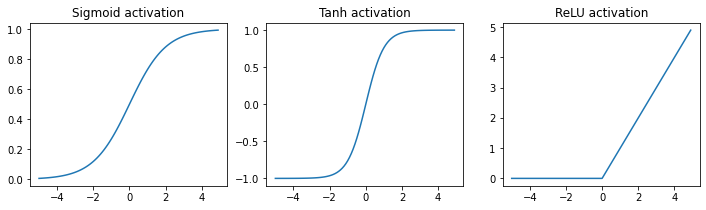

In [201]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

_ReLU 활성 함수 ($max(0,z)$)_ 는 신경망에서 __가장 널리 사용__ 되는 활성 함수입니다.<br>
하지만 보이는 것처럼, 각 활성화 함수는 고유한 제약 조건이 있으므로 상황에 따라 적절한 활성화 함수를 사용해야 합니다.<br>
예를들어, 만약 우리의 출력을 0 ~ 1로 제한한다면, <font color = blue>시그모이드</font>가 가장 적절합니다.

**NOTE**: 몇 몇 경우, ReLU 활성화 함수를 사용하는 것은 적절하지 않을 수 있습니다. <br>
예를 들어, 출력의 대부분이 음수인 경우 0 이하의 값은 0으로 취급되기 때문에 이 경우에는 ReLU를 사용하지 않아야 합니다.<br>
이 현상을 <font color = red>"dying ReLU"</font>라고 부르고 이는 해결하기 쉽지 않습니다.<br>
이러한 경우를 위해, 학습률을 낮추거나 [기타 ReLU 계열 활성 함수들](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7)을 사용할 수 있습니다. (ex. leaky ReLU, parametric ReLU(PReLU) 등)

# NumPy

이제 앞에서 정의한 선형 모델과 같지만, 활성화 함수를 통해 데이터의 비선형성을 매핑하는 MLP를 생성해보겠습니다.

**NOTE**: 이 섹션에서 다루는 수식과 코드가 약간 복잡하다 생각하는것은 정상입니다. 몇 번이고 다시 읽어 자신의 것으로 만드세요!

## Initialize weights

1. 모델의 가중치 $W$를 무작위로 초기화합니다. (이번 튜토리얼의 뒷 부분에서 더 효율적인 초기화 전략을 다룰 것입니다.)

In [202]:
# Initialize first layer's weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
print (f"W1: {W1.shape}")
print (f"b1: {b1.shape}")

W1: (2, 100)
b1: (1, 100)


## Model

2. 순방향 패스를 수행하고 확률을 받기위해 모델에 입력 $X$를 줍니다.

첫 번째로 우리는 첫번째 레이어에 입력을 줍니다.
  * $z_1 = XW_1$

In [203]:
# z1 = [NX2] · [2X100] + [1X100] = [NX100]
z1 = np.dot(X_train, W1) + b1
print (f"z1: {z1.shape}")

z1: (1083, 100)


다음으로 비선형 활성함수를 적용해보겠습니다. (이 경우 ReLU ($max(0,z)$))
  * $a_1 = f(z_1)$

In [204]:
# Apply activation function
a1 = np.maximum(0, z1) # ReLU
print (f"a_1: {a1.shape}")

a_1: (1083, 100)


활성화된 결과를 두 번째 레이어로 전달합니다.
  * $z_2 = a_1W_2$

In [205]:
# Initialize second layer's weights
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))
print (f"W2: {W2.shape}")
print (f"b2: {b2.shape}")

W2: (100, 3)
b2: (1, 3)


In [206]:
# z2 = logits = [NX100] · [100X3] + [1X3] = [NX3]
logits = np.dot(a1, W2) + b2
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (1083, 3)
sample: [ 0.0004134   0.0002782  -0.00118021]


두 번째 레이어를 통과해 나온 결과를 정규화하고 클래스 확률을 얻기 위해 softmax 함수를 적용합니다.
  * $\hat{y} = softmax(z_2)$

In [207]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1083, 3)
sample: [0.33352539 0.3334803  0.33299431]


## Loss

3. 타겟 값 $y$(ex. 클래스 2인 경우: [0, 0, 1])와 예측 값 $\hat{y}$(ex. [0.3, 0.3, 0.4]])을 비교해 목적 함수(손실 함수)로 손실 값 $J$를 얻습니다. <br>
대부분의 분류 문제를 위한 손실 함수들은 __크로스 엔트로피 손실 함수__입니다.
  * $J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}}) $

In [208]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)

## Gradients

4. 모델 가중치의 손실 $J(\theta)$의 경사를 계산하기

W2에 대한 손실의 기울기는 $\hat{y} = softmax(z_2)$ 때문에 로지스틱 회귀의 기울기와 같습니다.
 * $\frac{\partial{J}}{\partial{W_{2j}}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_{2j}}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_{2j}}} = - \frac{1}{\frac{e^{W_{2y}a_1}}{\sum_j e^{a_1W}}}\frac{\sum_j e^{a_1W}e^{a_1W_{2y}}0 - e^{a_1W_{2y}}e^{a_1W_{2j}}a_1}{(\sum_j e^{a_1W})^2} = \frac{a_1e^{a_1W_{2j}}}{\sum_j e^{a_1W}} = a_1\hat{y}$
  * $\frac{\partial{J}}{\partial{W_{2y}}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_{2y}}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_{2y}}} = - \frac{1}{\frac{e^{W_{2y}a_1}}{\sum_j e^{a_1W}}}\frac{\sum_j e^{a_1W}e^{a_1W_{2y}}a_1 - e^{a_1W_{2y}}e^{a_1W_{2y}}a_1}{(\sum_j e^{a_1W})^2} = \frac{1}{\hat{y}}(a_1\hat{y} - a_1\hat{y}^2) = a_1(\hat{y}-1)$

  W1 손실의 기울기는 두 개의 가중치를 통해 역 전파해야하므로 약간 까다롭습니다.
  * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_1}}  \frac{\partial{a_1}}{\partial{z_1}}  \frac{\partial{z_1}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $

In [209]:
# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [210]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)

## Update weights

5. 작은 학습률 $\alpha$를 사용해 가중치 $W$를 업데이트 합니다.<br> 업데이트는 잘못된 클래스 (j)에 대한 확률에 페널티를 주고 올바른 클래스 (y)에 대해 더 높은 확률을 주도록 합니다.
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$

In [211]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2

## Training

6. 모델이 잘 작동할 때까지 2 - 4 스텝을 반복합니다.

In [212]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [213]:
# Initialize random weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    logits = np.dot(a1, W2) + b2
    
    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%100 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2

Epoch: 0, loss: 1.099, accuracy: 0.243
Epoch: 100, loss: 0.551, accuracy: 0.680
Epoch: 200, loss: 0.223, accuracy: 0.912
Epoch: 300, loss: 0.131, accuracy: 0.951
Epoch: 400, loss: 0.090, accuracy: 0.976
Epoch: 500, loss: 0.069, accuracy: 0.985
Epoch: 600, loss: 0.056, accuracy: 0.994
Epoch: 700, loss: 0.048, accuracy: 0.996
Epoch: 800, loss: 0.043, accuracy: 0.997
Epoch: 900, loss: 0.039, accuracy: 0.997


In [214]:
class MLPFromScratch():
    def predict(self, x):
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)
        logits = np.dot(a1, W2) + b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [215]:
# Evaluation
model = MLPFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [216]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 1.00, test acc: 1.00


In [217]:
def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')

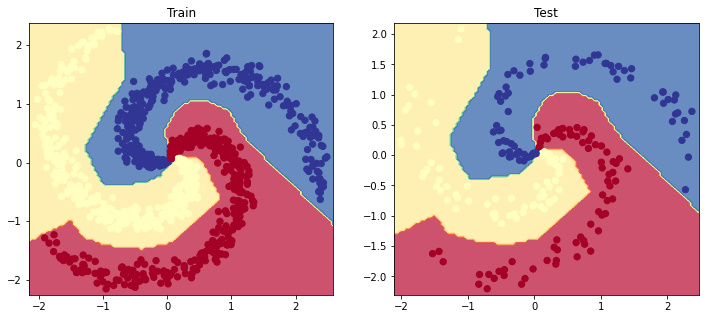

In [218]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test, y=y_test)
plt.show()

이제 PyTorch를 이용한 MLP 구현을 해보겠습니다.

# MLP

## Model

In [219]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [220]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


## Training

In [221]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [222]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [223]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [224]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [225]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.11, accuracy: 23.5
Epoch: 10 | loss: 0.66, accuracy: 55.9
Epoch: 20 | loss: 0.50, accuracy: 71.8
Epoch: 30 | loss: 0.37, accuracy: 88.4
Epoch: 40 | loss: 0.27, accuracy: 91.9
Epoch: 50 | loss: 0.21, accuracy: 93.8
Epoch: 60 | loss: 0.16, accuracy: 94.9
Epoch: 70 | loss: 0.14, accuracy: 96.6
Epoch: 80 | loss: 0.12, accuracy: 97.2
Epoch: 90 | loss: 0.10, accuracy: 97.9


## Evaluation

In [226]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0078, 0.0019, 0.9903], grad_fn=<SelectBackward>)
sample class: 2


In [227]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.99


<ipython-input-195-c4b3e1cd4909>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-195-c4b3e1cd4909>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


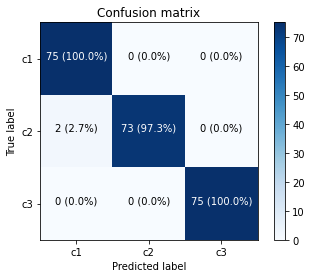

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.97      0.99        75
           2       1.00      1.00      1.00        75

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



In [228]:
# Metrics
plot_confusion_matrix(y_test, pred_test, classes=classes)
print (classification_report(y_test, pred_test))

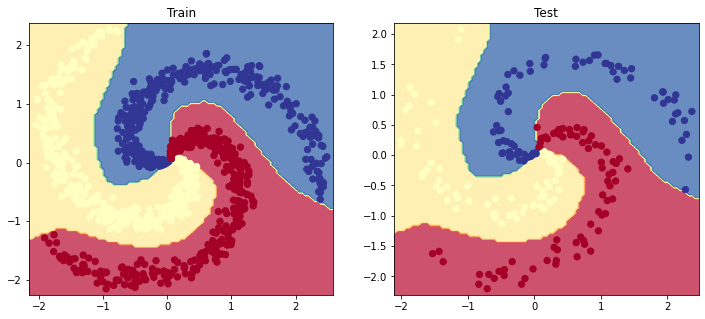

In [229]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

## Inference

In [230]:
# Inputs for inference
X_infer = pd.DataFrame([{'X1': 0.1, 'X2': 0.1}])
X_infer.head()

,X1,X2
0,0.1,0.1


In [231]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[0.30945845 0.30761858]]


In [232]:
# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
print (f"The probability of class {classes[_class.detach().numpy()[0]]} is {prob.detach().numpy()[0]*100.0:.0f}%")

The probability of class c1 is 94%


# 가중치 초기화

지금까지 작은 무작위 값으로 가중치를 초기화해 왔지만 이것은 훈련 _모델의 수렴_ 에 적합하지 않습니다.<br>
목표는 __모든 뉴런에 걸쳐 적절한 분포를 따르는 출력을 생성할 수 있는 가중치를 갖는 것__ 입니다. <br> 
우리는 affine(행렬 곱) 및 비선형 연산 전에 단위 분산을 갖도록 가중치에 적용함으로써 적절한 가중치 초기화를 할 수 있습니다.

**NOTE**: 많이 쓰이는 방법으로는 [xavier initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)이 있습니다.<br>
이 기법은 가중치를 초기화하여 데이터의 신호가 네트워크 깊숙이 도달 할 수 있도록 합니다.<br>
이외 다른 초기화 기법들은 [여기](https://pytorch.org/docs/stable/nn.init.html)를 참조하기 바랍니다.

In [233]:
from torch.nn import init

In [234]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu')) 
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

# Dropout

모델을 일반화하는(테스트 데이터에서 잘 작동하는) 가장 좋은 테크닉은 학습 데이터의 수를 증가시키는 것이지만 이건 언제나 가능한 방법은 아닙니다.<br>
다행히도, 더 강력한 모델을 만드는데 도움이 되는 정규화 및 드롭아웃과 같은 방법들이 존재합니다.

드롭아웃(Dropout)은 )__뉴런의 출력을 0으로 만드는 기법__ 입니다.<br>
전체 뉴런 중 `dropout_p`%에 대해 이 작업을 수행하고, __매 배치마다 달라집니다__.<br>
매번 다른 뉴런들에 이 작업을 수행하기 때문에 드롭 아웃은 뉴런이 데이터에 너무 많이 학습되는 것을 방지하고 샘플링 전략 역할도 합니다.


<div align="left">
<img src="https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" width="350">
</div>

* [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

In [235]:
DROPOUT_P = 0.1 # % of the neurons that are dropped each pass

In [236]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # dropout
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu')) 
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) 
        z = self.dropout(z) # dropout
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [237]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# Overfitting(과적합)

_신경망_ 은 비선형 관계를 포착하는데에는 뛰어나지만 학습 데이터에 너무 민감하여 __쉽게 과적합__ 되어 테스트 데이터에 _일반화를 실패_ 하는 경우가 자주 생깁니다. <br>
아래 예시에서 완전히 무작위 데이터를 생성해 [$2*N*C + D$](https://arxiv.org/abs/1611.03530) 히든 유닛을 가진 모델을 학습할 수 있습니다.<br>
학습 결과는 좋지만(~70%) 과적합으로 인해 좋지 않은 테스트 성능을 보이게 됩니다.<br>
이러한 과적합 문제를 해결하기 위한 전략을 다룰 것입니다.

In [238]:
NUM_EPOCHS = 500
NUM_SAMPLES_PER_CLASS = 50
LEARNING_RATE = 1e-1
HIDDEN_DIM = 2 * NUM_SAMPLES_PER_CLASS * NUM_CLASSES + INPUT_DIM # 2*N*C + D

In [239]:
# Generate random data
X = np.random.rand(NUM_SAMPLES_PER_CLASS * NUM_CLASSES, INPUT_DIM)
y = np.array([[i]*NUM_SAMPLES_PER_CLASS for i in range(NUM_CLASSES)]).reshape(-1)
print ("X: ", format(np.shape(X)))
print ("y: ", format(np.shape(y)))

X:  (150, 2)
y:  (150,)


In [240]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
print ("X_train:", X_train.shape)
print ("y_train:", y_train.shape)
print ("X_val:", X_val.shape)
print ("y_val:", y_val.shape)
print ("X_test:", X_test.shape)
print ("y_test:", y_test.shape)

X_train: (107, 2)
y_train: (107,)
X_val: (20, 2)
y_val: (20,)
X_test: (23, 2)
y_test: (23,)


In [241]:
# Standardize the inputs (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [242]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [243]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=302, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=302, out_features=3, bias=True)
)>


In [244]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [245]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.16, accuracy: 35.5
Epoch: 20 | loss: 1.05, accuracy: 39.3
Epoch: 40 | loss: 0.99, accuracy: 48.6
Epoch: 60 | loss: 0.93, accuracy: 53.3
Epoch: 80 | loss: 0.94, accuracy: 57.9
Epoch: 100 | loss: 0.91, accuracy: 57.0
Epoch: 120 | loss: 0.86, accuracy: 57.9
Epoch: 140 | loss: 0.91, accuracy: 56.1
Epoch: 160 | loss: 0.94, accuracy: 60.7
Epoch: 180 | loss: 0.85, accuracy: 58.9
Epoch: 200 | loss: 0.91, accuracy: 57.9
Epoch: 220 | loss: 0.90, accuracy: 60.7
Epoch: 240 | loss: 0.83, accuracy: 71.0
Epoch: 260 | loss: 0.79, accuracy: 67.3
Epoch: 280 | loss: 0.81, accuracy: 64.5
Epoch: 300 | loss: 0.80, accuracy: 64.5
Epoch: 320 | loss: 0.88, accuracy: 58.9
Epoch: 340 | loss: 0.86, accuracy: 65.4
Epoch: 360 | loss: 0.76, accuracy: 65.4
Epoch: 380 | loss: 0.84, accuracy: 61.7
Epoch: 400 | loss: 0.78, accuracy: 69.2
Epoch: 420 | loss: 0.83, accuracy: 59.8
Epoch: 440 | loss: 0.82, accuracy: 68.2
Epoch: 460 | loss: 0.80, accuracy: 63.6
Epoch: 480 | loss: 0.78, accuracy: 67.3


In [246]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.1756, 0.3662, 0.4582], grad_fn=<SelectBackward>)
sample class: 2


In [247]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.65, test acc: 0.39


<ipython-input-195-c4b3e1cd4909>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-195-c4b3e1cd4909>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


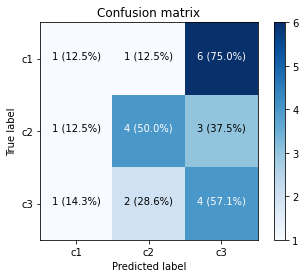

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.57      0.50      0.53         8
           2       0.31      0.57      0.40         7

    accuracy                           0.39        23
   macro avg       0.40      0.40      0.37        23
weighted avg       0.41      0.39      0.37        23



In [248]:
# Classification report
plot_confusion_matrix(y_true=y_test, y_pred=pred_test, classes=classes)
print (classification_report(y_test, pred_test))

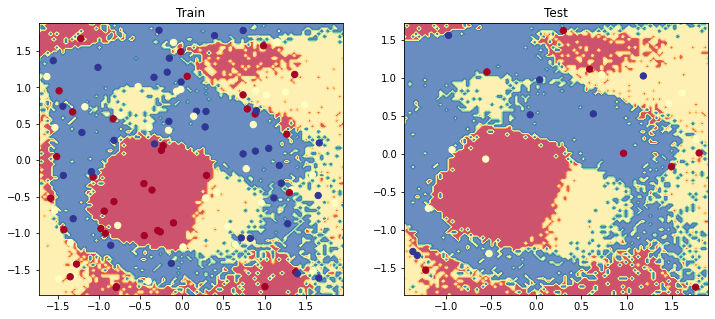

In [249]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

_과소적합(높은 편향)_ 하는 __간단한 모델__ 로 시작해 __good fitting__ 을 하는 것이 중요합니다.<br>
간단한 모델(선형/로지스틱 회귀)로 시작하면 __복잡한 모델을 추가하지 않고도 오류를 포착__ 할 수 있기 때문입니다.